In [22]:
import os
import pandas as pd

walking_forward=[]
raise_half_handR=[]
raise_half_handL=[]
handR_rest=[]
handL_rest=[]
forward_rest=[]
stand_act=[]
stand_rest=[]


channel=["AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"]

for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/walking_forward/action/'):
    walking_forward.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/walking_forward/action/{j}')[channel].to_numpy())
    
for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/raise_half_handR/action/'):
    raise_half_handR.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/raise_half_handR/action/{j}')[channel].to_numpy())    
    
for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/raise_half_handL/action/'):
    
    raise_half_handL.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/raise_half_handL/action/{j}')[channel].to_numpy())        

for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/raise_half_handL/rest/'):
    
    handL_rest.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/raise_half_handL/rest/{j}')[channel].to_numpy())        
    
for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/raise_half_handR/rest/'):
    
    handR_rest.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/raise_half_handR/rest/{j}')[channel].to_numpy())            
    
for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/original/rest/'):
    
    stand_rest.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/original/rest/{j}')[channel].to_numpy())            

for j in os.listdir(f'./drive/MyDrive/clean_record_eeg/original/action/'):
    
    stand_act.append(pd.read_csv(f'./drive/MyDrive/clean_record_eeg/original/action/{j}')[channel].to_numpy())            
    


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
walking_forward=np.array(walking_forward)
walking_forward=walking_forward.reshape(walking_forward.shape[0],8,128,-1)

raise_half_handL=np.array(raise_half_handL)
raise_half_handL=raise_half_handL.reshape(raise_half_handL.shape[0],8,128,-1)

raise_half_handR=np.array(raise_half_handR)
raise_half_handR=raise_half_handR.reshape(raise_half_handR.shape[0],8,128,-1)

stand_act=np.array(stand_act)
stand_act=stand_act.reshape(stand_act.shape[0],8,128,-1)

handR_rest=np.array(handR_rest)
handR_rest=handR_rest.reshape(handR_rest.shape[0],8,128,-1)

handL_rest=np.array(handL_rest)
handL_rest=handL_rest.reshape(handL_rest.shape[0],8,128,-1)
#rest=np.concatenate([rest,handL_rest,handR_rest,stand_rest,stand_act])




In [24]:
rng = np.random.default_rng()
walking_forward=rng.choice(walking_forward,size=255,axis=0)
rest=rng.choice(stand_act,size=255,axis=0)
raise_half_handL=rng.choice(raise_half_handL,size=255,axis=0)
raise_half_handR=rng.choice(raise_half_handR,size=255,axis=0)
#rest=rng.choice(rest,size=255,axis=0)



In [25]:
x=np.concatenate([walking_forward,raise_half_handL,raise_half_handR,rest])
x.shape

(1020, 14336)

In [6]:
y=np.array([0]*255+[1]*255+[2]*255+[3]*255)
y=pd.get_dummies(y).to_numpy()
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[start:end, start: end]
        if dimension == 2:
            return x[:, start:end, start: end]
        if dimension == 3:
            return x[start:end, start:end, start:end, start: end]
        if dimension == 4:
            return x[start:end, start:end, start:end, start:end, start: end]
    return Lambda(func)
import math
def slice_model(model_input,unit,row_num,col_num,term):
  return [crop(2,col_num-(j+unit),col_num-j) for col in range(0,row_num-unit+1,term)]

In [ ]:
import sys

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, GlobalMaxPooling2D,Lambda,concatenate,Conv2D, MaxPooling2D,GlobalAveragePooling2D, ConvLSTM2D
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.models import Model
import tensorflow as tf
import os


def mk_model(filepath=None):
    
    FILTER_SIZE=3
    NUM_FILTERS=20
    INPUT_SIZE=19
    MAXPOOL_SIZE=2
    BATCH_SIZE=3
    STEPS_PER_EPOCH=48//BATCH_SIZE
    EPOCHS=1000
    
    model_input=Input(shape=(15,14,7))
    model_output=Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),activation='relu')(model_input)
    model_output= MaxPooling2D((MAXPOOL_SIZE,MAXPOOL_SIZE))(model_output)
    model_output=Dropout(0.5)(model_output)
    densors = []
    s=slice_model(model_input,5,7,3,3)
    
    for idx in s:
        model_output=Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),activation='relu')(model_input)
        model_output=Dropout(0.5)(model_output)
    
        model_output=GlobalMaxPooling2D()(model_output)
        densors.append(model_output)

    model_output=concatenate(densors)
    
    model_output=Dense(units=512,activation='relu')(model_output)
    model_output=Dense(units=1,activation='sigmoid')(model_output)
    model = Model(inputs = model_input, outputs = model_output)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model


In [9]:
import sys

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling3D,Input, GlobalMaxPooling3D, GlobalMaxPooling2D,Lambda,concatenate,Conv3D,Conv2D, MaxPooling2D, AveragePooling2D,GlobalAveragePooling3D,ConvLSTM2D,BatchNormalization, Reshape, LSTM
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model
import tensorflow as tf
import os


def mk_model(filepath=None):
    
    FILTER_SIZE=3
    NUM_FILTERS=32
    INPUT_SIZE=19
    MAXPOOL_SIZE=2
    BATCH_SIZE=3
    STEPS_PER_EPOCH=48//BATCH_SIZE
    EPOCHS=1000
    
    model_input=Input(shape=(8,128,14,1))
    
    model_output=ConvLSTM2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),activation='relu',padding="same",return_sequences=True)(model_input)
    model_output=Dropout(0.5)(model_output)
    model_output=BatchNormalization()(model_output)
    
    model_output=ConvLSTM2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),activation='relu',padding="same",)(model_output)
    model_output=Dropout(0.5)(model_output)
    model_output=BatchNormalization()(model_output)
    
    model_output=Conv2D(5, (FILTER_SIZE, FILTER_SIZE),activation='relu')(model_output)
    model_output=Dropout(0.5)(model_output)
    
    model_output=Flatten()(model_output)

    model_output=Dense(units=300,activation='relu')(model_output)
    model_output=Dense(units=300,activation='relu')(model_output)
    model_output=Dropout(0.5)(model_output)
    model_output=Dense(units=300,activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(model_output)
    model_output=Dense(units=4,activation='softmax')(model_output)
    model = Model(inputs = model_input, outputs = model_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


In [23]:
x_train.shape

(652, 8, 128, 14)

(816, 8, 128, 14) (816, 4)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 128, 14, 1)]   0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 8, 128, 14, 32)    38144     
_________________________________________________________________
dropout (Dropout)            (None, 8, 128, 14, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 128, 14, 32)    128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 128, 14, 32)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 14, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None

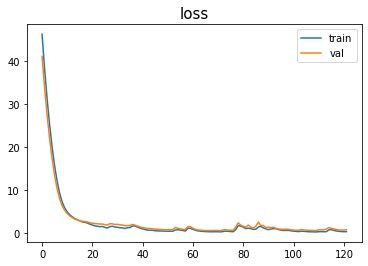

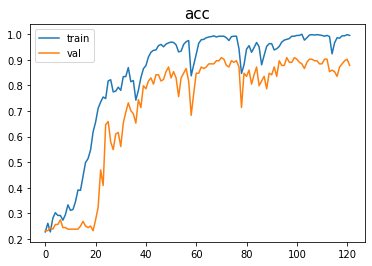

6/6 [==============================] - 1s 178ms/step - loss: 0.4988 - accuracy: 0.9024
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 128, 14, 1)]   0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 8, 128, 14, 32)    38144     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 128, 14, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 128, 14, 32)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 128, 14, 32)       73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 14, 32)       0         
______________________________________

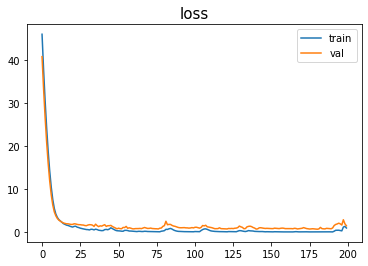

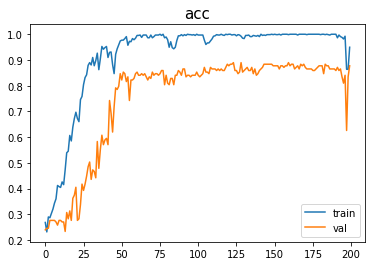

6/6 [==============================] - 1s 161ms/step - loss: 0.7444 - accuracy: 0.8773
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 128, 14, 1)]   0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 8, 128, 14, 32)    38144     
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 128, 14, 32)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 128, 14, 32)    128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 128, 14, 32)       73856     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 14, 32)       0         
______________________________________

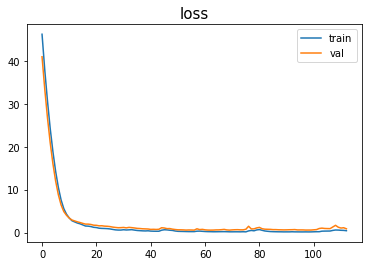

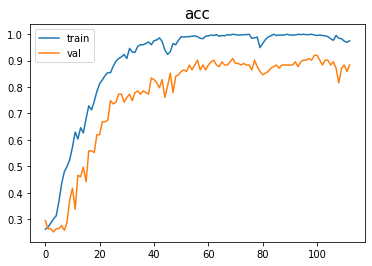

6/6 [==============================] - 1s 160ms/step - loss: 0.5591 - accuracy: 0.9018
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 128, 14, 1)]   0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 8, 128, 14, 32)    38144     
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 128, 14, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 128, 14, 32)    128       
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 128, 14, 32)       73856     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 14, 32)       0         
______________________________________

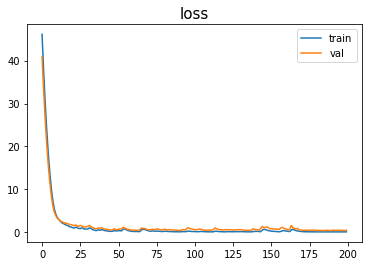

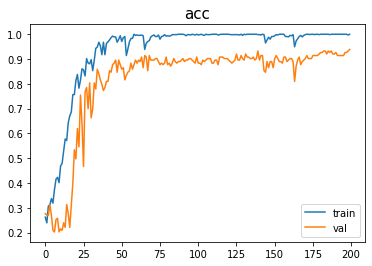

6/6 [==============================] - 1s 159ms/step - loss: 0.4305 - accuracy: 0.9264
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 8, 128, 14, 1)]   0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 8, 128, 14, 32)    38144     
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 128, 14, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 128, 14, 32)    128       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 128, 14, 32)       73856     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 14, 32)       0         
______________________________________

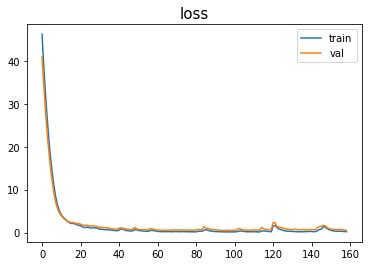

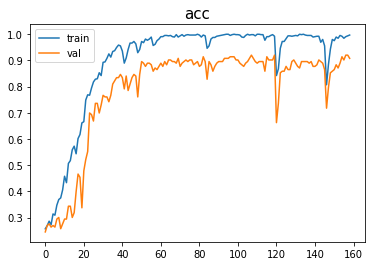

6/6 [==============================] - 1s 160ms/step - loss: 0.4773 - accuracy: 0.9080


In [10]:
# import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

x_tra,x_test,y_tra,y_test=train_test_split(x,y,train_size=0.8,stratify=y,random_state=18)
print(x_tra.shape,y_tra.shape)
kf=KFold(n_splits=5,shuffle=True)
train_score=[]
test_score=[]
val_score=[]

idx=0

val_list=[]

for train_index, test_index in kf.split(x_tra):
    callback_list = [
    EarlyStopping( #성능 향상이 멈추면 훈련을 중지
    monitor='val_loss',  #모델 검증 정확도를 모니터링
    patience=50 ),       #1 에포크 보다 더 길게(즉, 2에포크 동안 정확도가 향상되지 않으면 훈련 중지
    ModelCheckpoint( #에포크마다 현재 가중치를 저장
    filepath=f'./mod{idx}.h5', #모델 파일 경로
    monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
    save_best_only=True,
    mode='auto',
    verbose=1)]
    
    x_train,x_val=x_tra[train_index],x_tra[test_index]
    
    y_train,y_val=y_tra[train_index],y_tra[test_index]
    
    
  
    model=mk_model()
    print(model.summary())
    hist=model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val),batch_size=x_train.shape[0]//10,callbacks=callback_list)
    
    
    plt.plot(hist.history['loss'],label='train'+str(idx))
    plt.plot(hist.history['val_loss'],label='train'+str(idx))
    plt.title('loss',fontsize=15)
    plt.legend(['train','val'])
    plt.show()
    plt.plot(hist.history['accuracy'],label='train'+str(idx))
    plt.plot(hist.history['val_accuracy'],label='train'+str(idx))
    plt.legend(['train','val'])
    plt.title('acc',fontsize=15)
    plt.show()
    model=load_model(f'./mod{idx}.h5')
    
    train_score.append(model.evaluate(x_train,y_train))
    test_score.append(model.evaluate(x_test,y_test))
    val_score.append(model.evaluate(x_val,y_val))
    idx+=1

